In [1]:
# Import functions from py scripts
from basic_functions import *
from bathymetry_functions import *

# Import librerias from python
import matplotlib as mpl
import datetime
import glob
import os
import matplotlib.dates as mdates
import mat73
from pytides2.tide import Tide
import pytides2.constituent  as cons
import pytides2.astro as astro
import matplotlib.pylab as pl
from scipy import signal
from pytz import timezone
import pytz
import missingno as msno
from netCDF4 import Dataset, num2date
import mat73
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Personalizar graficas
plt.style.use("default")
mpl.rcParams['xtick.labelsize']=12
mpl.rcParams['ytick.labelsize']=12
mpl.rcParams['font.sans-serif'] = "Century Gothic"
mpl.rcParams['font.family'] = "Century Gothic"
mpl.rcParams['font.weight'] = 'normal'
def fig_params(ax):
    ax.grid()    
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['top'].set_color('gray')
    ax.tick_params('y', colors='tab:gray')
    ax.tick_params('x', colors='tab:gray')
    for label in ax.get_yticklabels():
        label.set_color('k')
        label.set_size(13)
    for label in ax.get_xticklabels():
        label.set_color('k')
        label.set_size(13)

import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_hycom_data(path):
    data = Dataset(f'{path}', 'r')
    try: 
        lat = np.array(data.variables['latitude'][:])
        lon = np.array(data.variables['longitude'][:])
    except: 
        lat = np.array(data.variables['lat'][:])
        lon = np.array(data.variables['lon'][:])
    nctime = np.array(data.variables['time'][:])
    t_unit = data.variables['time'].units
    t_cal = data.variables['time'].calendar
    time = num2date(nctime,units=t_unit,calendar=t_cal)#Date time
    time_str = np.array([time[i].strftime("%Y-%m-%d %H:%M:%S") for i in range (len(time))])
    time = np.array([datetime.datetime.strptime(time_str[i], "%Y-%m-%d %H:%M:%S") for i in range (len(time))])
    # ______Cambiar la zona horaria utc 0 a utc -5________________
    utc = pytz.utc
    # col_zone = timezone('America/Bogota')
    col_zone = timezone('GMT')
    time2=np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time])
    loc_co =np.array([i.astimezone(col_zone) for i in time2])
    time = np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])

    salt = np.array(data.variables['salinity'][:]).astype(float)
    salt[salt<=-30000] = np.nan
    temp = np.array(data.variables['water_temp'][:]).astype(float)
    temp[temp<=-30000] = np.nan
    depth = np.array(data.variables['depth'][:]) 

    dic_ = {'time':time,'lat': lat, 'lon': lon,'depth': depth,  'salt': salt, 'temp': temp }
    return dic_



def min_ind (value, vector, delta):
    """Función para encontrar la mínima diferencia entre dos celdas
    Input: 
    - Value: valor a encontrar 
    - Vector: vectores donde quiere encontrar dicho valor
    - delta: radio para encontrar ese valor 
    ----------------------------------------------------------------------
    Output: 
    - Ind: indices donde mayor se aproxima el valor buscado a los vectores
    """
    indices = np.where((vector > value-(delta)) & (vector < value+(delta)))[0]
    for i in indices: 
        try :
            if vector[i] - value < vector[i+1] - value:
                ind = i
            else:
                ind = i+1
        except:
            print('**********ERROR************')
    
    print('Indice:',ind,', Valor:', vector[ind], ', Valor real:', value)
    return ind


In [3]:
def plot_cells_data_base (lon:np.array, lat:np.array, plot_dfbat:bool, df_bat: pd.DataFrame = None):
    """
    Esta función plotea los centros de las celdas donde hay información de la base de datos
    -----------------------------------------------------------------------------------------
    Input:
    ------
    - lon: arreglo de las longitudes de los datos obtenidos de la base de datos
    - lat:  arreglo de las latitudes de los datos obtenidos de la base de datos
    - plot_df_bat: True/ False: para plotear o no la ubicación de la malla con respecto a la base de datos 
    ------------------------------------------------------------------------------------------------------
    Output: 
    -------
    - Figure
    """ 

    fig = plt.figure(figsize = (10,5))
    ax1 = fig.add_subplot(projection = ccrs.PlateCarree())
    ax1.set_extent([np.min(lon)-0.1,np.max(lon)+0.1, np.min(lat)-0.1, np.max(lat)+0.1])

    gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    ax1.stock_img()
    ax1.add_feature(cf.LAND, zorder= 10)
    ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan', zorder = 11 )
    # ax1.add_feature(cf.RIVERS, lw = 2)
    ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')


    colors_cm = pl.cm.jet(np.linspace(0,1, len(lon)*len(lat)))
    i = 0
    for loni in (lon):
        for lati in (lat):
            ax1.scatter(loni, lati, marker = 'o', s = 10, label = 'Cords '+str(lati)+'-'+str(loni), color = colors_cm[i])
            i = i +1

    if plot_dfbat == True: 
        ax1.scatter(df_bat['lon'], df_bat['lat'],color = 'red', s=1)
    ax1.set_yticklabels(ax1.get_yticks() , color='gray',size = 12)
    ax1.set_xticklabels(ax1.get_xticks() , color='gray',size = 12)
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.tick_params('y', colors='tab:gray')
    ax1.tick_params('x', colors='tab:gray')




    #------------ Labels de cartopy--------------- 
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 10, 'color': 'gray','weight': 'bold' }
    gl.xlabel_style = {'size': 10, 'color': 'gray', 'weight': 'bold' }


    ax1.spines['left'].set_color('gray')
    ax1.spines['right'].set_color('gray')
    ax1.spines['bottom'].set_color('gray')
    ax1.spines['top'].set_color('gray')

    # _= fig.legend(loc='upper center', bbox_to_anchor=(0.85, 0.9),
    #           fancybox=True, shadow=True, ncol=2, fontsize = 8,prop=prop2, labelcolor = 'gray')
    fig.suptitle('Localización de los pixeles',size=12);
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.subplots_adjust(hspace=0.25)

# Descargar datos de hycom

In [4]:
def convert_to_NETCDF_data(url_data_server:str, path:str, file_name: str ):
    
    data_server = Dataset(f'{url_data_server}', 'r')
    lat = np.array(data_server.variables['lat'][:])
    lon = np.array(data_server.variables['lon'][:])
    nctime = np.array(data_server.variables['time'][:])
    t_unit = data_server.variables['time'].units
    t_cal = data_server.variables['time'].calendar
    depth = np.array(data_server.variables['depth'][:]) 

    salt = np.array(data_server.variables['salinity'][:]).astype(float)
    temp = np.array(data_server.variables['water_temp'][:]).astype(float)


    #-------------- Crear archivo netcdf----------------------------------
    data_nc = Dataset(f'{path}\{file_name}.nc', "w", format="NETCDF4")

    # Crear las dimensiones 
    time_dim = data_nc.createDimension('time', len(nctime))
    lat_dim = data_nc.createDimension('lat', len(lat))
    lon_dim = data_nc.createDimension('lon', len(lon))
    depth_dim = data_nc.createDimension('depth', len(depth))

    # Crear las variables 
    time_var = data_nc.createVariable('time', 'f4', ('time'))
    lat_var = data_nc.createVariable('lat', 'f4', ('lat'))
    lon_var = data_nc.createVariable('lon', 'f4', ('lon'))
    depth_var = data_nc.createVariable('depth', 'f4', ('depth'))
    temp_var = data_nc.createVariable('water_temp', 'f4', ('time', 'depth', 'lat', 'lon'), fill_value = -30000.0)
    salt_var = data_nc.createVariable('salinity', 'f4', ('time', 'depth', 'lat', 'lon'), fill_value = -30000.0)

    # Asignación de atributos
    time_var.units = t_unit
    time_var.calendar = t_cal
    lat_var.units = data_server.variables['lat'].units
    lon_var.units = data_server.variables['lon'].units
    depth_var.units = data_server.variables['depth'].units
    temp_var.units = data_server.variables['water_temp'].units
    salt_var.units = data_server.variables['salinity'].units
    temp_var.missing_value = data_server.variables['water_temp'].missing_value
    salt_var.missing_value = data_server.variables['salinity'].missing_value
    temp_var.fil_value = -30000.0
    salt_var.fil_value = -30000.0

    # Ingresar los datos
    time_var[:] = nctime
    lat_var[:] = lat
    lon_var[:] = lon
    depth_var[:] = depth
    temp_var[:] = temp
    salt_var[:] = salt

    data_nc.close

In [5]:
def indices_dimensiones(url:str, lat_down:float, lat_upper:float, lon_left:float, lon_right:float, date_ini:datetime.datetime, date_fin:datetime.datetime):
    """_summary_

    Parameters
    ----------
    url : str
        Urel de la base de datos del que se obtiene eligiendo por defecto los atributos
    lat_down : float
        Latitud más abajo
    lat_upper : float
        Latitud más arriba
    lon_left : float
        Longitud más a la isquierda
    lon_right : float
        Longitud más a la derecha
    date_ini : datetime.datetime
        Fecha inicial del periodo a descargar
    date_fin : datetime.datetime
        Fecha final del periodo a descargar

    Returns
    -------
    _int_
    idown_lat, iupper_lat, ileft_lon, iright_lon, i_inidate, i_findate : Enteros de las ubicaciones dentro de la base de datos donde 
    se encuentra los datos solicitados
    """



    data_dim = Dataset(f'{url}')
    lat = np.array(data_dim.variables['lat'][:])
    lon = np.array(data_dim.variables['lon'][:])
    nctime = np.array(data_dim.variables['time'][:])
    t_unit = data_dim.variables['time'].units
    t_cal = data_dim.variables['time'].calendar
    time = num2date(nctime,units=t_unit,calendar=t_cal)#Date time
    utc = pytz.utc
    col_zone = timezone('GMT')
    time2=np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time])
    loc_co =np.array([i.astimezone(col_zone) for i in time2])
    time = np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])

    idown_lat = np.where(lat >= lat_down)[0][0]
    iupper_lat = np.where(lat >= lat_upper)[0][0] +1
    ileft_lon = np.where(lon >= lon_left)[0][0]
    iright_lon = np.where(lon >= lon_right)[0][0] +1

    splits_time = t_unit.split(' ')
    units_time = datetime.datetime.strptime(f'{splits_time[-2]} {splits_time[-1]}', "%Y-%m-%d %H:%M:%S")
    hours_ini = (date_ini - units_time).days*24
    hours_fin = (date_fin - units_time).days*24
    if date_ini.month == 1: 
        i_inidate = 0
        i_findate = np.where(nctime== hours_fin)[0][0] -1
    elif date_ini.month == 12:
        i_inidate = np.where(nctime== hours_ini)[0][0]
        i_findate = len(nctime)-1
    else:
        i_inidate = np.where(nctime== hours_ini)[0][0]
        i_findate = np.where(nctime== hours_fin)[0][0] -1
    



    # dic_indices = {'down_lat': idown_lat, 'upper_lat': iupper_lat, 'left_lon':ileft_lon, 'right_lon':iright_lon,
    #                 'inidate':i_inidate, 'findate': i_findate}
    return idown_lat, iupper_lat, ileft_lon, iright_lon, i_inidate, i_findate


# def convert_to_NETCDF_data(url_data_server:str, path:str, file_name: str ):
#     with Dataset(f'{url_data_server}', 'r') as src, Dataset(f'{path}\{file_name}.nc', "w", format="NETCDF4") as dst:
#         # copy attributes
#         for name in src.ncattrs():
#             dst.setncattr(name, src.getncattr(name))
#         # copy dimensions
#         for name, dimension in src.dimensions.items():
#             dst.createDimension(
#                 name, (len(dimension) if not dimension.isunlimited else None))
#         # copy all file data except for the excluded
#         for name, variable in src.variables.items():
#             # if name not in toexclude:
#             x = dst.createVariable(name, variable.datatype, variable.dimensions)
#             dst.variables[name][:] = src.variables[name][:]
#             dst.variables[name].units = src.variables[name].units


#             if name == 'time': 
#                 dst.variables[name].calendar = src.variables[name].calendar
            
#             try:
#                 dst.variables[name].missing_value = src.variables[name].missing_value
#                 dst.variables[name].fill_value = src.variables[name]._FillValue
#             except:
#                 pass


def time_vector_first_day (year:int, year_end:int, month_start:str, month_end: str):
    """_summary_

    Parameters
    ----------
    year : int
        Año a descargar los datos
    year_end : int
        Año final de descarga de datos (si solo se descarga un periodo del año entonces es igual year), si se descarga
        todo el año es un año más que year
    month_start : str
        Mes inicial para crear el vector de tiempos
    month_end : str
        Mes final para crear el vector de tiempos (si es un año completo entonces es igual 1, y un año más que year)

    Returns
    -------
    _pd.Series_
        Serie de tiempo con los meses inciando en cada mes
    """
    start_date = f'{year}-{month_start}-01'  # Fecha de inicio
    end_date = f'{year_end}-{month_end}-01'    # Fecha de fin
    date_range = pd.date_range(start=start_date, end=end_date, freq='MS')
    first_day_of_month = date_range.to_series().dt.to_period('M').dt.start_time
    return first_day_of_month



## Descargar datos por mes 

In [10]:
year = 2016
month = '12'
url_dim = 'https://tds.hycom.org/thredds/dodsC/GLBv0.08/expt_57.2?depth[0:1:39],lat[0:1:3250],lon[0:1:4499],time[0:1:2207]'




if month == '12':
    date_ini = datetime.datetime(year,int(month),1)
    date_fin = datetime.datetime(year+1,1,1)
else :
    date_ini = datetime.datetime(year,int(month),1)
    date_fin = datetime.datetime(year,int(month)+1,1,0)

print(date_ini, date_fin) 
down_lat, upper_lat, left_lon, right_lon, inidate, findate   = indices_dimensiones(url = url_dim, 
                                    lat_down = 12.37 ,lat_upper =  12.6, 
                                    lon_left = -81.9 ,lon_right = -81.6,
                                    date_ini = date_ini, date_fin = date_fin)

depth_slide = '0:2:39'
lat_slide = f'{down_lat}:1:{upper_lat}'
lon_slide = f'{left_lon}:1:{right_lon}'
time_slide = f'{inidate}:2:{findate}'

url_data = f'https://tds.hycom.org/thredds/dodsC/GLBv0.08/expt_57.2?depth[{depth_slide}],lat[{lat_slide}],lon[{lon_slide}],time[{time_slide}],water_temp[{time_slide}][{depth_slide}][{lat_slide}][{lon_slide}],salinity[{time_slide}][{depth_slide}][{lat_slide}][{lon_slide}]'

# https://tds.hycom.org/thredds/dodsC/GLBv0.08/expt_57.2?depth[0:1:39],lat[0:1:3250],lon[0:1:4499],time[0:1:2207],water_temp[0:1:0][0:1:0][0:1:0][0:1:0],salinity[0:1:0][0:1:0][0:1:0][0:1:0]

path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BASES_DE_DATOS\CLIMATOLOGIA_HYCOM\DATA_VFINAL'
file_name = f'Hycom_temp_sal_{year}_{month}'
convert_to_NETCDF_data(url_data_server = url_data, path= path ,file_name=file_name)

2016-12-01 00:00:00 2017-01-01 00:00:00


## Descargar datos por año por mes 

In [7]:
year = 2015
url_dim = 'http://tds.hycom.org/thredds/dodsC/GLBv0.08/expt_53.X/data/2015?depth[0:1:39],lat[0:1:3250],lon[0:1:4499],time[0:1:2860]'
time_vector = time_vector_first_day (year = year, year_end = year+1, month_start = '01', month_end = '01')

for i, time in enumerate(time_vector):
    month = time.month
    year = time.year

    date_ini = datetime.datetime(year,month,time.day)
    date_fin = datetime.datetime(time_vector[i+1].year,time_vector[i+1].month,time.day)
    print(f'*******month :{month}**************')
    print(date_ini, date_fin)

    down_lat, upper_lat, left_lon, right_lon, inidate, findate   = indices_dimensiones(url = url_dim, 
                                        lat_down = 12.37 ,lat_upper =  12.6, 
                                        lon_left = -81.9 ,lon_right = -81.6,
                                        date_ini = date_ini, date_fin = date_fin)

    depth_slide = '0:2:39'
    lat_slide = f'{down_lat}:1:{upper_lat}'
    lon_slide = f'{left_lon}:1:{right_lon}'
    time_slide = f'{inidate}:2:{findate}'
    url_data = f'http://tds.hycom.org/thredds/dodsC/GLBv0.08/expt_53.X/data/2015?depth[{depth_slide}],lat[{lat_slide}],lon[{lon_slide}],time[{time_slide}],water_temp[{time_slide}][{depth_slide}][{lat_slide}][{lon_slide}],salinity[{time_slide}][{depth_slide}][{lat_slide}][{lon_slide}]'
    
    path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BASES_DE_DATOS\CLIMATOLOGIA_HYCOM\DATA_VFINAL'
    if month < 10:
        file_name = f'Hycom_temp_sal_{year}_0{month}'
    else:        
        file_name = f'Hycom_temp_sal_{year}_{month}'
    
    try:
        convert_to_NETCDF_data(url_data_server = url_data, path= path ,file_name=file_name)
        print('***********Descargado con EXITO!!!***********')
    except:
        print('ERROR: _______No se descargo ><________') 
        pass


*******month :1**************
2015-01-01 00:00:00 2015-02-01 00:00:00
***********Descargado con EXITO!!!***********
*******month :2**************
2015-02-01 00:00:00 2015-03-01 00:00:00
***********Descargado con EXITO!!!***********
*******month :3**************
2015-03-01 00:00:00 2015-04-01 00:00:00
***********Descargado con EXITO!!!***********
*******month :4**************
2015-04-01 00:00:00 2015-05-01 00:00:00
***********Descargado con EXITO!!!***********
*******month :5**************
2015-05-01 00:00:00 2015-06-01 00:00:00
***********Descargado con EXITO!!!***********
*******month :6**************
2015-06-01 00:00:00 2015-07-01 00:00:00
***********Descargado con EXITO!!!***********
*******month :7**************
2015-07-01 00:00:00 2015-08-01 00:00:00
***********Descargado con EXITO!!!***********
*******month :8**************
2015-08-01 00:00:00 2015-09-01 00:00:00
***********Descargado con EXITO!!!***********
*******month :9**************
2015-09-01 00:00:00 2015-10-01 00:00:00
**

IndexError: index 0 is out of bounds for axis 0 with size 0

 # Comprobar ubicación de archivos

In [11]:
path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\BAT_NORTE_RECTANGULAR_100m'
name_file_grid = 'BAT_SAI_NORTE.grd'
name_file_deep = 'BAT_SAI_NORTE.dep'
name_file_coast = 'COAST_LINE.mat'

num_lineas = 21
n_rows = 106 #83
n_cols = 102

df_lc = read_coast_line(path= path, name_file = name_file_coast)
X, Y, Z = read_grid_file_d3d(num_btw_lines = num_lineas, ncols = n_cols, 
                             nrows = n_rows, path = path, name_file_grid = name_file_grid, name_file_deep = name_file_deep)
df_bat_sai = df_project_grid_grid(n_cols = n_cols, n_rows = n_rows, X= X, Y = Y)
# bat_figure(df_lc= df_lc,X= X, Y= Y, Z=Z[:-1,:-1], delta_lim= 500,delta = 450 ,size = (8, 6), active_puntos_obs = False)

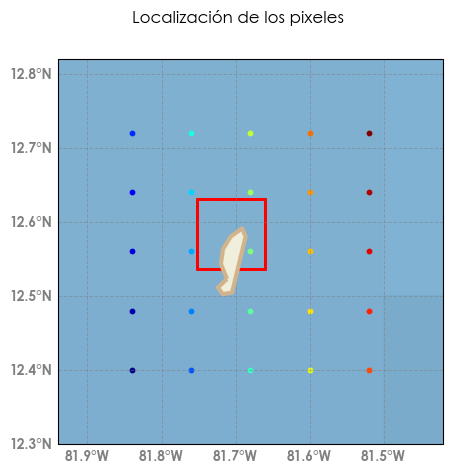

In [12]:
path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BASES_DE_DATOS\CLIMATOLOGIA_HYCOM\Scripts'
name_file = "Hycom_temp_sal_2013_01_prueba.nc"
dic_prop = read_hycom_data(path = f'{path}\{name_file}')
lat = dic_prop['lat']
lon = dic_prop['lon']
plot_cells_data_base (lon = lon, lat = lat, plot_dfbat = True, df_bat = df_bat_sai)